# Unsupervised KDE analysis

<h5 style="text-align:right; margin-right:15px"> 2024-07-31 09:39</h5>

* Load source data from `files/dr4_2_class_2_features.csv'

### Data selection cut: "0.15<Ep<10 & variability<30"

association_class,blazar,pulsar,Gal,egal,unID
total,2283,316,223,88,3903
selected,502,306,171,35,2245
%,22,97,77,40,58


## Create KDE functions instead of ML training

* Features: sqrt_d, log_epeak, diffuse 

Apply to unIDs + bcus

saved KDE setup to `files/kde_data.csv`

---
# Galacticity analysis
Try a 1-D KDE with G, and the populations psr, msp,and blazar

Select subset to supress blazars: "d>0.5 & Ep<4" 

subset,blazar,msp,psr,unID
Count,77,157,115,1234


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715e8815210>
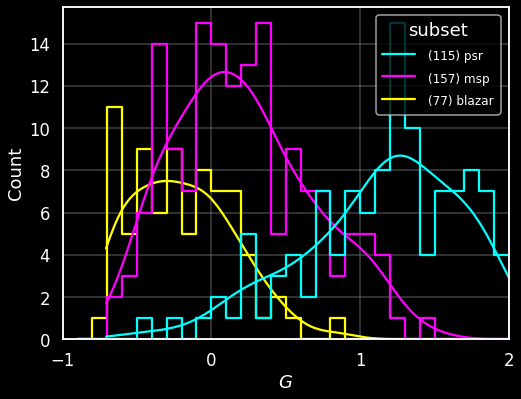

In [1]:
%reset -f
%run pylib/kde_doc dark paper
data = kde_setup()

show(f"""---
# Galacticity analysis
Try a 1-D KDE with G, and the populations psr, msp,and blazar""")
data.groupby('subset').size()
show(f"""Select subset to supress blazars: "{(cut:='d>0.5 & Ep<4')}" """)
data_cut = data.query(cut)
show(pd.Series(data_cut.groupby('subset').size(), name='Count'))

fig,ax = plt.subplots(figsize=(8,6))
(sns.histplot(data_cut, 
              x=data.diffuse.clip(-0.9,2), hue='subset', palette=palette, #+['0.5'], 
              hue_order='psr msp blazar'.split(), kde=True,
              bins=np.arange(-0.9,2.01, 0.1), element='step',fill=False)
  .set(**G_kw())
)
update_legend(ax, data_cut, 'subset', fontsize=12)
show(fig)

## Generate the G-KDE functions
Make a `GalKDE` subclass to reflect at G=2

{'blazar': Gaussian_kde with columns ['diffuse'], 77 data points,
 'msp': Gaussian_kde with columns ['diffuse'], 157 data points,
 'psr': Gaussian_kde with columns ['diffuse'], 115 data points}

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715e8a5e1d0>
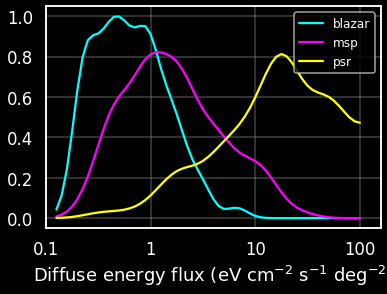

In [2]:
show("""## Generate the G-KDE functions
Make a `GalKDE` subclass to reflect at G=2""")
from pylib.kde import Gaussian_kde
class GalKDE(Gaussian_kde):
    def evaluate(self,x):
        return super().evaluate(x)+super().evaluate(4-x)
        
subgrp = data_cut.groupby('subset')

kde_dict = dict( (name, GalKDE(df, cols=['diffuse'], bw_method=0.3),)
                for name, df in subgrp if name!='unID')
show(kde_dict)

fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(-0.9, 2.01, 0.05)
for (name, gkde), color in zip(kde_dict.items(), palette):
    ax.plot(x, gkde.evaluate(x), label=name, color=color);
ax.legend(fontsize=12);
ax.set(**diffuse_kw());
show(fig)

In [3]:
show(f"""## Apply to unID
Add G-kde value columns to the unid subset""")

unid = subgrp.get_group('unID').iloc[:,:-6].copy() #  remove last 6 cols
g = unid.diffuse # G values for unID

for name, gkde in kde_dict.items():
    unid[name] = gkde.evaluate(g)  
k_data = unid.iloc[:,-3:]
# show(k_data.head())


show(r"""## The unbinned likelihood

$x$:   independent variable: list of coefficients to apply to KDE<br>
model: N X 3 scaled kde values.<br>
$\mu$: predicted probability. <br>
$ \log(L)=\sum[ \log(\mu) - \mu] $
""")
class GlogLike:
    def __init__(self, unid):
        self.kdata = unid.iloc[:,-3:]
        
    def __call__(self, x):
        """ return -log like """
        mu = (self.kdata * x).sum(axis=1).clip(1e-4,None)
        return -np.sum(np.log(mu)-mu)
        
    def maximize(self, x0 = [0.74, 0.41, 1.63]):
        from scipy import optimize
        opt = optimize.minimize(self, x0, method=None,
                               bounds= [(0,None),(0,None),(0,None)])
        return opt


## Apply to unID
Add G-kde value columns to the unid subset

## The unbinned likelihood

$x$:   independent variable: list of coefficients to apply to KDE<br>
model: N X 3 scaled kde values.<br>
$\mu$: predicted probability. <br>
$ \log(L)=\sum[ \log(\mu) - \mu] $

In [4]:
show(f"""## Optimization """)
self = GlogLike(unid) #.query('diffuse<0 | diffuse>1.3')
opt = self.maximize([0.74, 1.0, 1.63] )
if not opt.success:
    print(f'Warning: {opt.message}', file=sys.stderr)
show(f"""Fit: {opt.x.round(3)}""")
hinv = opt.get('hess_inv', None)
if hinv is not None:
    cov = hinv.todense()
    sigs = np.sqrt(cov.diagonal())
    corr = cov / np.outer(sigs,sigs)
    
    show(f"""Errors: {sigs.round(3)}""")
    show(f"""Correlations:""")
    show(corr.round(2))
else: show('no covariance')

## Optimization 

Fit: [0.642 0.538 1.525]

Errors: [0.235 0.235 0.219]

Correlations:

array([[ 1.  , -0.74,  0.11],
       [-0.74,  1.  , -0.7 ],
       [ 0.11, -0.7 ,  1.  ]])

In [6]:
show(f"""### Adjust normalization in range G>{(Gmax:=1.4)}""")
Nx = len(unid.query(f'diffuse>{Gmax}'))
show(f""" {Nx} unid's to normalize to""")

tbl = {}
x = np.arange(-0.9, 2.01, 0.05)
for (name, gkde), v in zip(kde_dict.items(), opt.x, ):
    tbl[name] = pd.Series( gkde.evaluate(x)*v, index=x)
tbl = pd.DataFrame.from_dict(tbl)
tbl['sum']=tbl.sum(axis=1)
factor = tbl.query(f'index>{Gmax}')['sum'].sum()
 

### Adjust normalization in range G>1.4

142 unid's to normalize to

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715e8726500>
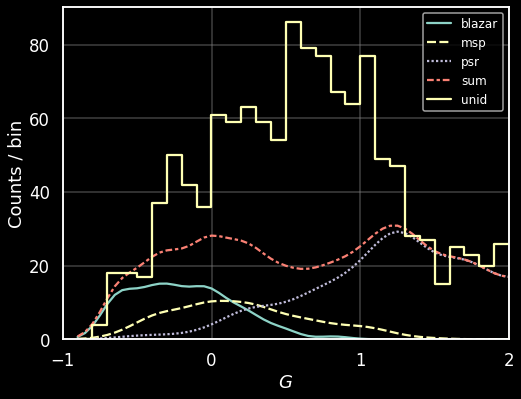

In [7]:

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(tbl*factor*2);
bins =np.arange(-0.9,2.01, 0.1)
sns.histplot(unid,ax=ax, x='diffuse', element='step', fill=False, bins=bins, label='unid');
ax.legend(fontsize=12);
ax.set(**G_kw(), ylabel='Counts / bin')
show(fig)


---
# Spectral plots  

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715e87ff760>
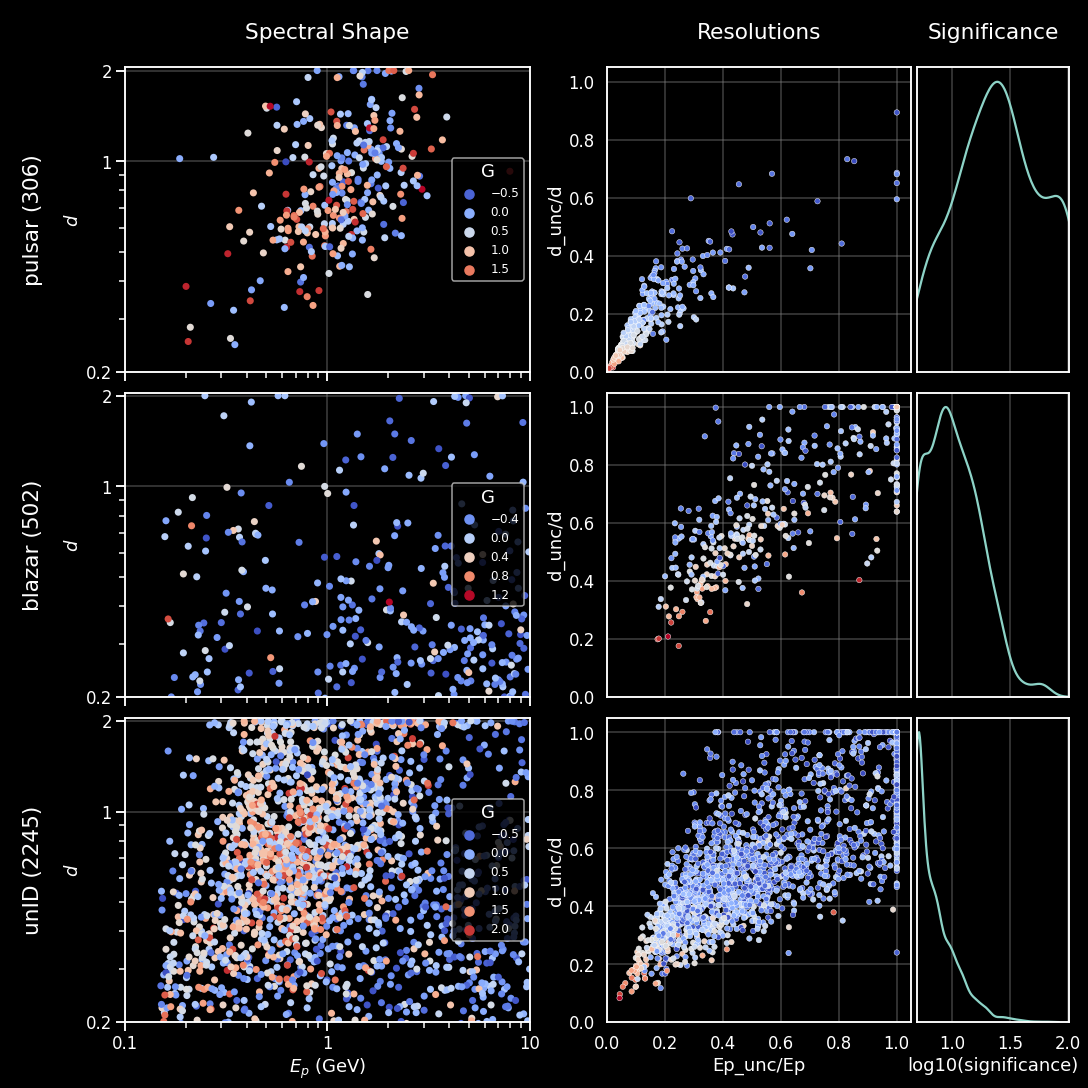

In [11]:
show(f"""---
# Spectral plots  """)
show_fig(multi_spectra,data)

### Select well-measured subset: 
Cut =  '(d_unc/d)**2 + (Ep_unc/Ep)**2 < 1'

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715dbd67d30>
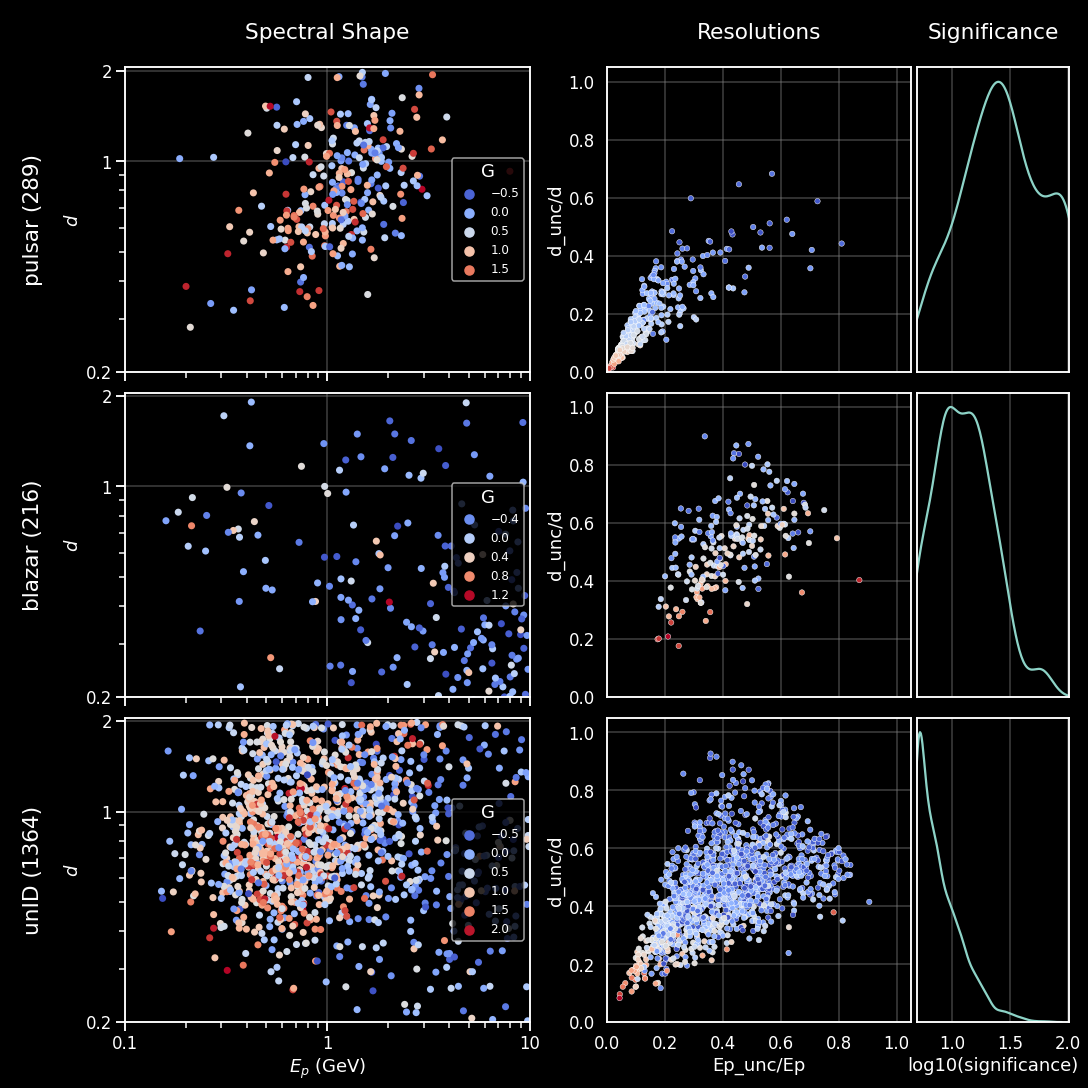

In [12]:
show(f"""### Select well-measured subset: 
   Cut =  '{(mcut:="(d_unc/d)**2 + (Ep_unc/Ep)**2 < 1")}'""")
show_fig(multi_spectra,data.query(mcut))

## Compare $E_p$ above and below 1 GeV

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715da2a8dc0>
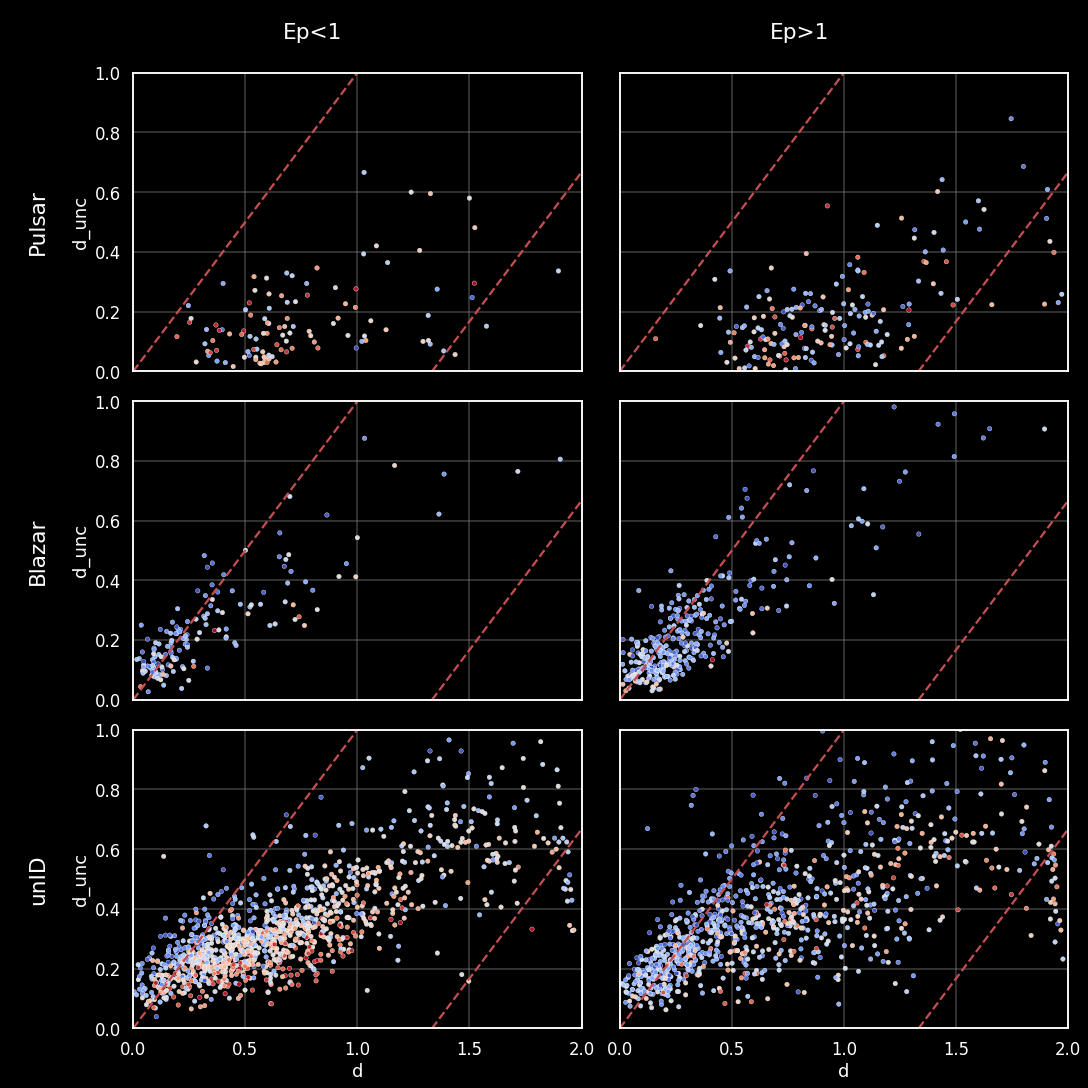

In [13]:
show(f"""## Compare $E_p$ above and below 1 GeV""")
show_fig(multi_d, data)

## Play with restricted pulsar, significance> 5 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715e859dd80>
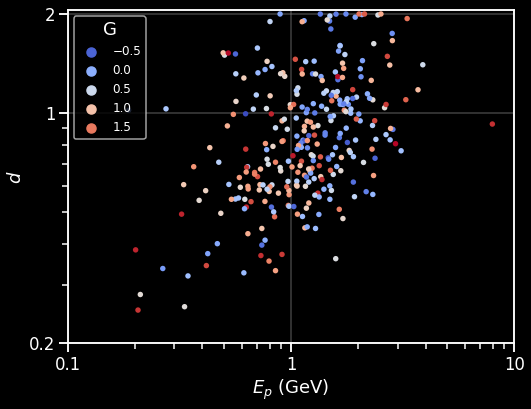

In [14]:
show(f"""## Play with restricted pulsar, significance> {(sigcut:=5)} """)
df= data.query(f'association_class=="pulsar" & significance>{sigcut}')
# df = data.query(f'association_class=="unID" & {mcut}')

# def d_kw(axis='x'):
#     d = dict(label='$d$', scale='log', ticks=[0.2, 1, 2], ticklabels='0.2 1 2'.split(), lim=(0.2,2.05))
#     return dict( (axis+k, v) for k,v in d.items() )

# def ep_kw(axis='x'):
#     d = dict(label='$E_p$ (GeV)', scale='log', ticks=[0.1,1,10], ticklabels='0.1 1 10'.split(),
#              lim=(0.1,10))
#     return dict( (axis+k, v) for k,v in d.items() )

def hue_kw(df, ax):
    return dict( hue=df.diffuse, palette='coolwarm')
        # hue=np.log10(df.significance), palette='coolwarm')
    
def d_vs_Ep(df, ax=None,  leg_title='G'):
    fig, ax = plt.subplots(figsize=(8,6)) if ax is None else (ax.figure, ax)
    sns.scatterplot(df, ax=ax, x=df.Ep, y=df.d.clip(0.05,2), s=30, edgecolor='none', 
         **hue_kw(df, ax))
    ax.set( **d_kw('y'),  **ep_kw('x')  )
    ax.legend(fontsize=12, loc='upper left', title=leg_title)
    ax.tick_params(which="both", bottom=True, left=True)
    return fig
    
show_fig(d_vs_Ep, df,  leg_title='G')
# dir(ax.yaxis.get_minor_ticks()[0])

In [15]:
show('### Compare with 3PC')
show('figures/3PC-Figure2-right.png')

### Compare with 3PC

Image file figures/3PC-Figure2-right.png not found.


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7715e8090e50>

In [16]:
df = df['significance d Ep Ep_unc d_unc diffuse'.split()].sort_values('Ep')
df

,significance,d,Ep,Ep_unc,d_unc,diffuse
4FGL-DR4,,,,,,
4FGL J0659.7+1416,43.549,1.020,0.187,0.017,0.100,-0.010
4FGL J1828.4-1059,11.708,0.384,0.201,0.141,0.137,1.884
4FGL J1757.9-2419,6.868,0.252,0.206,0.270,0.164,1.831
4FGL J0205.7+6449,13.416,0.281,0.211,0.043,0.031,0.710
4FGL J0540.3-6920,28.461,0.337,0.266,0.067,0.053,-0.139
...,...,...,...,...,...,...
4FGL J1422.5-6137,54.326,1.098,3.264,0.154,0.097,1.625
4FGL J1853.3-0005,7.077,1.937,3.309,0.516,0.398,1.523
4FGL J1824.2-0621,25.356,1.177,3.701,0.311,0.206,1.066


Loaded Fermi 4FGL gll_psc_v32.fit: 7195 entries


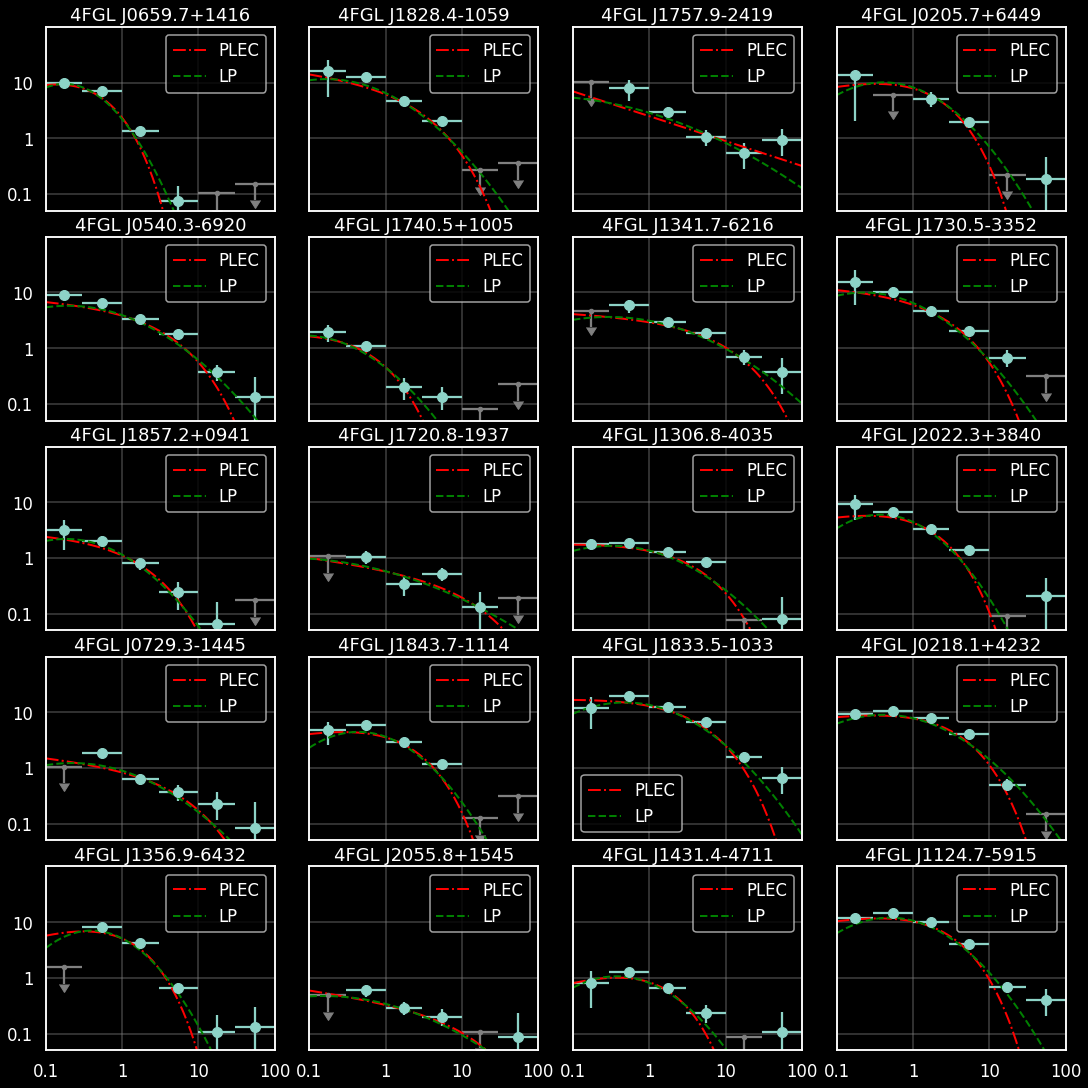

In [17]:
from pylib.catalogs import Fermi4FGL
dr4 = Fermi4FGL()

def seds_plot(dr4, name, ax=None):
    fig, ax = plt.subplots(figsize=(8,5)) if ax is None else (ax.figure, ax)
    dr4.band_plot(name, ax=ax, specfun=False, ms=10);
    sf = dr4.get_specfunc(name, func_name= 'PLEC4',)
    sf.sed_plot(ax=ax, plot_kw=dict(color='red', ls='-.',), label='PLEC'  )
    sf = dr4.get_specfunc(name, func_name= 'LP',)
    sf.sed_plot(ax=ax, plot_kw=dict(color='green', ls='--',), label='LP'  )
    ax.set(ylim=(0.02,20), yticks=[0.1,1,10], yticklabels='0.1 1 10'.split(), 
           xticks=[0.1,1,10,100],xticklabels='0.1 1 10 100'.split(),
          title=name)
    ax.legend(fontsize=10)
    
    ax.legend() 
    return fig
fig, axx = plt.subplots(5,4, figsize=(15,15),layout='constrained',sharex=True, sharey=True)
for ax, name in zip(axx.flat, df.index):
    seds_plot(dr4, name, ax) ;
    ax.set(xlabel='', ylabel='', ylim=(0.05, 100))

